In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
from skrf.media import *
from skrf import Frequency
import json

[jpa-model.html](jpa-model.html)

In [19]:
fghz  = np.linspace(4,9,1601)
f = fghz*1e9
sopen = fghz*0j + 1
open_network = rf.Network(frequency=f, s=sopen, z0=50)
omega = 2*np.pi*f
f_coax = Frequency(fghz[0], fghz[len(fghz)-1], len(fghz), 'GHz')

In [18]:
while True:
    file_object = open("control.json", "r")
    try:
        control = json.loads(file_object.read())
    except ValueError:
        pass
    file_object.close()
    C_shunt = control['C0']
    L_shunt = control['LJmin']/np.abs(np.cos(2*np.pi*control['phi']))
    Y_c_shunt = 1j*omega*control['C0']
    Y_l_shunt = 1/(1j*omega*L_shunt)
    c_in = control['Cin']
    Z_c_in = 1/(1j*2*np.pi*f*c_in)
    c_shunt_network = rf.Circuit.ShuntAdmittance(f, Y_c_shunt, name='shunt_admittance')
    l_shunt_network = rf.Circuit.ShuntAdmittance(f, Y_l_shunt, name='shunt_admittance2')
    cin_series_network = rf.Circuit.SeriesImpedance(f,Z_c_in,name='cin')
    jpa = cin_series_network**l_shunt_network**c_shunt_network**open_network
    coax = coaxial.Coaxial(f_coax,Dint=0.0005,Dout=0.001675,epsilon_r=2.1,sigma=1.2e7,z0_port=50)
    coax_length = coax.line(control['coax_length'], unit = 'm')
    coax_jpa = coax_length**cin_series_network**l_shunt_network**c_shunt_network**open_network
    phase =  coax_jpa.s_deg_unwrap[:,0,0]
    model = {}
    model['fghz'] = fghz.tolist()
    model['phase'] = coax_jpa.s_deg_unwrap[:,0,0].tolist()
    file_object = open("model.json", "w")
    json_string = file_object.write(json.dumps(model))
    file_object.close()


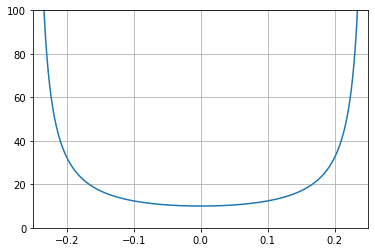

In [14]:
phi = np.linspace(-0.5,0.5,1000)
L = control['LJmin']/np.abs(np.cos(2*np.pi*phi))
plt.plot(phi,L/1e-12)
plt.ylim(0,100)
plt.xlim(-0.25,0.25)
plt.grid()
